# QC and filtering scRNAseq data on developmental habenula of Mmu
The data is retrived as fastq files, trimmed and mapped using STARMAP. Spliced, unspliced and total RNA files (coutc, coutb and coutt) are merged, renamed and cleaned up on HPC (High Performance Cluster).

The dataset has a total of 2 plates per 8 different timepoint, except for timepoint 12, they only have one plate. Divided up into 3 batches.

Author: Juliska E Boer

Date: 03 Nov 2020

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.sparse import csr_matrix

#settings
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.figdir = "../../figures/embryoHb/"
sc.settings.set_figure_params(dpi=80)

/Users/liekevandehaar/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.8.0 louvain==0.6.1
scvelo==0.1.25  scanpy==1.4.6  anndata==0.7.1  loompy==3.0.6  numpy==1.18.1  scipy==1.4.1  matplotlib==3.1.3  sklearn==0.22.1  pandas==1.0.1  

For better visualization of some plots, different colorschemes for continuous data are made.

In [2]:
c_cont_red = mpl.colors.LinearSegmentedColormap.from_list('custom_red', 
                                             [(0, 'silver'),
                                              (0.1, (1, 0.82, 0.82)),
                                              (0.2, (1, 0.67, 0.67)),
                                              (0.3, (1, 0.58, 0.58)),
                                              (0.4, (1, 0.48, 0.48)),
                                              (0.5, (1, 0.38, 0.38)),
                                              (0.6, (1, 0.29, 0.29)),
                                              (0.7, (1, 0.22, 0.22)),
                                              (0.8, (1, 0.15, 0.15)),
                                              (0.9, (0.67, 0.09, 0.09)),
                                              (1, (0.54, 0, 0))], N=128)
c_cont_green = mpl.colors.LinearSegmentedColormap.from_list('custom_green', 
                                             [(0, 'silver'),
                                              (0.1, (0.50, 0.93, 0.60)),
                                              (0.2, (0.4, 0.89, 0.5)),
                                              (0.3, (0.3, 0.81, 0.4)),
                                              (0.4, (0.2, 0.73, 0.3)),
                                              (0.5, (0.1, 0.69, 0.2)),
                                              (0.6, (0, 0.62, 0.185)),
                                              (0.7, (0, 0.55, 0.16)),
                                              (0.8, (0, 0.47, 0.15)),
                                              (0.9, (0, 0.36, 0.11)),
                                              (1, (0, 0.29, 0.06))], N=128)
c_cont_blue = mpl.colors.LinearSegmentedColormap.from_list('custom_blue', 
                                             [(0, 'silver'),
                                              (0.1, (0.67, 0.77, 1)),
                                              (0.2, (0.58, 0.68, 1)),
                                              (0.3, (0.48, 0.58, 1)),
                                              (0.4, (0.38, 0.48, 1)),
                                              (0.5, (0.29, 0.39, 1)),
                                              (0.6, (0.22, 0.32, 1)),
                                              (0.7, (0.15, 0.25, 1)),
                                              (0.8, (0.09, 0.19, 1)),
                                              (0.9, (0, 0.1, 0.75)),
                                              (1, (0, 0.1, 0.5))], N=128)

## Import data
All three the files; total RNA, spliced and unspliced, are loaded in. The total RNA file is the main file, and the spliced and unspliced are added as layers in the RNA file.

In [3]:
dataset = sc.read('../../data/input/merged_series_Habenula.coutt_total.tsv').T
spliced = sc.read('../../data/input/merged_series_Habenula.coutt_spliced.tsv').T
unspliced = sc.read('../../data/input/merged_series_Habenula.coutt_unspliced.tsv').T
print(dataset, spliced, unspliced)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
AnnData object with n_obs × n_vars = 5756 × 38086  AnnData object with n_obs × n_vars = 5756 × 38086  AnnData object with n_obs × n_vars = 5756 × 38086 


In [4]:
adata = dataset
adata.layers["spliced"] = spliced.X
adata.layers["unspliced"] = unspliced.X
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.85 0.15]


AnnData object with n_obs × n_vars = 5756 × 38086 
    layers: 'spliced', 'unspliced'

"adata.X" shows the count table, "adata.obs" shows information about the cells and "adata.var" shows information about the genes.

## Quality assessment

In [5]:
sc.pp.filter_cells(adata, min_genes=0) #calculate the number of genes and add as column in observations (cells).
sc.pp.filter_cells(adata, min_genes=1) #remove cells with no reads

In the cell names and the gene names, more information is stored. This information is broken down to seperate columns in the observations (cells) and variables (genes).

In [6]:
adata.var['ENS_names'] = adata.var_names.str.split('_').str[0]
adata.var['geneid'] = adata.var_names.str.split('_').str[1]
adata.var['feature'] = adata.var_names.str.split('__').str[1]
adata.var['chr'] = adata.var_names.str.split('__').str[2]
adata.var['fullname'] = adata.var_names
adata.obs['plate'] = adata.obs_names.str.split('__').str[0].str.split('_').str[1]
adata.obs['platebatch'] = adata.obs_names.str.split('__').str[1].str.split('_').str[2]
adata.obs['stage'] = adata.obs_names.str.split('___').str[1].str.split('_').str[0]
adata.obs['well_no'] = adata.obs_names.str.split('__').str[2]
adata

AnnData object with n_obs × n_vars = 5756 × 38086 
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname'
    layers: 'spliced', 'unspliced'

In order to determine the quality of the sequencing, ERCC spike-in genes are added to each well in the plates. Those genes are synthesized RNA with poly-A tail, which enables them for sequencing. When assessing the amount of ERCC reads per well (cell), you can determine the sequencing quality of the cell.

In [7]:
ERCC_genes = adata.var_names.str.startswith('ERCC')
adata.obs['ERCC_genes'] = np.sum(adata[:, ERCC_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_total_counts'] = adata.X.sum(axis=1)

As ERCC spike-in genes have no biological relevance, they are removed from the data.

In [8]:
non_ERCC = [name for name in adata.var_names if not name.startswith('ERCC')]
adata = adata[:, non_ERCC] 
adata

View of AnnData object with n_obs × n_vars = 5756 × 37994 
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname'
    layers: 'spliced', 'unspliced'

Besides ERCC genes, mitochondrial genes are also important for quality assessment, as the mitochondria (mt) plays a role in activating apoptosis. This indicates that mitochondrial levels determine variability in cell death.

In [9]:
mito_genes = adata.var_names.str.endswith('MT')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)

Trying to set attribute `.obs` of view, copying.


The mt genes might effect downstream analysis, so they are also removed from the dataset.

In [10]:
non_mito = [name for name in adata.var_names if not name.endswith('MT')]
adata = adata[:, non_mito]
adata

View of AnnData object with n_obs × n_vars = 5756 × 37957 
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname'
    layers: 'spliced', 'unspliced'

Determine the amount of biological relevant reads per cell, and give the variables (genes) clear names.

In [11]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata.var_names = adata.var_names.str.split('_').str[1]
adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 5756 × 37957 
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname'
    layers: 'spliced', 'unspliced'

We also determine the ribosomal genes per cell.

In [12]:
sc.pp.filter_cells(adata, min_genes=1)
percent_ribo = adata.var_names.str.startswith('Rp')
adata.obs['percent_ribo'] = np.sum(adata[:, percent_ribo].X, axis=1) / np.sum(adata.X, axis=1)

filtered out 19 cells that have less than 1 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Determine more information about the type of genes that are sequenced.

In [13]:
ft_list = ["protein_coding", "lincRNA", "antisense", "miRNA", "bidirectional_promoter_lncRNA", "snoRNA"]
for ft in ft_list:
    name = "percent_" + ft
    name_s = "sum_" + ft
    adata.obs[name] = np.sum(adata.X[:, adata.var['feature'] == ft], axis=1) / np.sum(adata.X, axis=1)
    if ft != "protein_coding" and ft != "snoRNA":
        adata.obs[name_s] = np.sum(adata.X[:, adata.var['feature'] == ft], axis=1)

adata

AnnData object with n_obs × n_vars = 5737 × 37957 
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname'
    layers: 'spliced', 'unspliced'

Print the results of the assessments of the cells and genes.

In [14]:
print(np.median(adata.obs['ERCC_genes']), 'median % are ERCC_genes before filtering')
print(np.median(adata.obs['percent_mito']), "median mito_genes/total before filtering, without ERCC")
print(np.median(adata.obs['n_total_counts']), "median number of reads with ERCC per cell")
print(np.median(adata.obs['n_counts']), "median number of reads per cell, without ERCC and mito")
print(np.median(adata.obs['percent_ribo']), "median % of ribosomal genes per cell")
print(np.median(adata.obs['n_genes']), "median number of genes per cell, without ERCC and mito")
print(np.median(adata.obs['percent_protein_coding']), "median % of protein_coding genes per cell")
print(np.median(adata.obs['percent_lincRNA']), "median % of lincRNA genes per cell")
print(np.median(adata.obs['percent_antisense']), "median % of antisense genes per cell")
print(np.median(adata.obs['percent_miRNA']), "median % of miRNA genes per cell")
print(np.median(adata.obs['percent_bidirectional_promoter_lncRNA']), "median % of bidirectional_promoter_lncRNA genes per cell")
print(np.median(adata.obs['percent_snoRNA']), "median % of snoRNA genes per cell")
print(np.median(adata.obs['sum_miRNA']), "median of total miRNA genes per cell")
print(np.median(adata.obs['sum_antisense']), "median of total antisense genes per cell")
print(np.median(adata.obs['sum_lincRNA']), "median of total lincRNA genes per cell")

0.14104305 median % are ERCC_genes before filtering
0.059842546 median mito_genes/total before filtering, without ERCC
8482.801 median number of reads with ERCC per cell
6680.2266 median number of reads per cell, without ERCC and mito
0.015038619 median % of ribosomal genes per cell
3156.0 median number of genes per cell, without ERCC and mito
0.9563224 median % of protein_coding genes per cell
0.0141808465 median % of lincRNA genes per cell
0.0027587856 median % of antisense genes per cell
0.0021600274 median % of miRNA genes per cell
0.0003666694 median % of bidirectional_promoter_lncRNA genes per cell
0.0 median % of snoRNA genes per cell
21.02275 median of total miRNA genes per cell
21.000977 median of total antisense genes per cell
90.1738 median of total lincRNA genes per cell


### Plotting the quality measurements
In order to visualize the distribution of the quality measures, we make violin plots. Also divided up by each timepoint.

... storing 'plate' as categorical
... storing 'platebatch' as categorical
... storing 'stage' as categorical
... storing 'well_no' as categorical
... storing 'geneid' as categorical
... storing 'feature' as categorical
... storing 'chr' as categorical


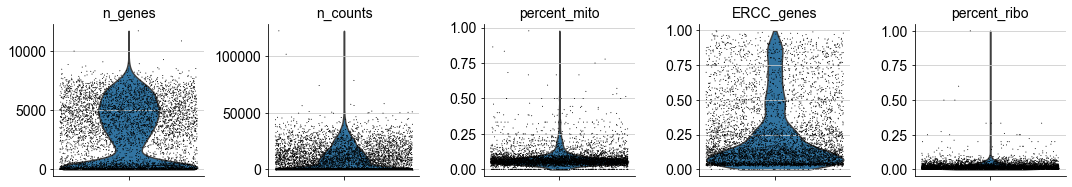

In [15]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito','ERCC_genes','percent_ribo'],
             jitter=0.4, multi_panel=True)

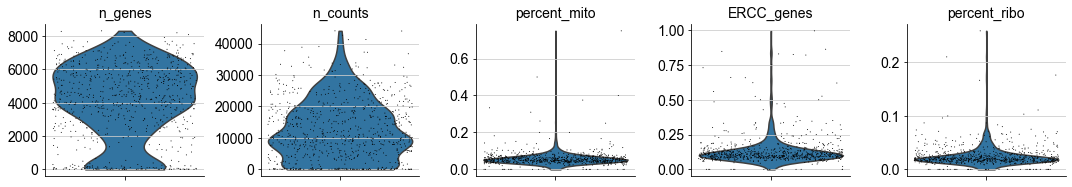

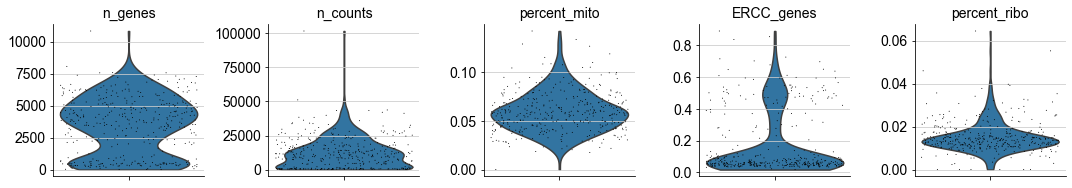

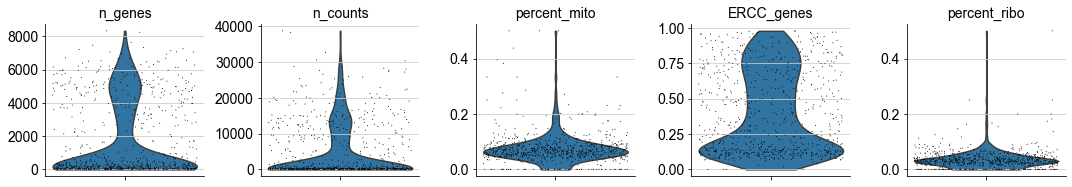

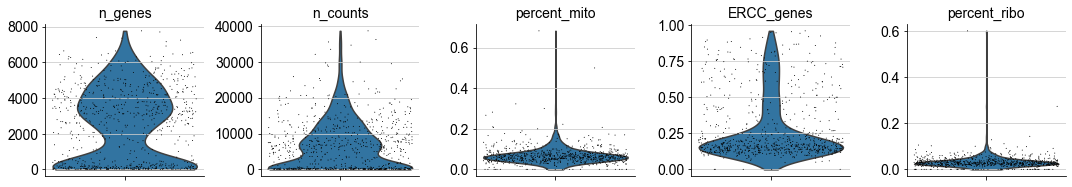

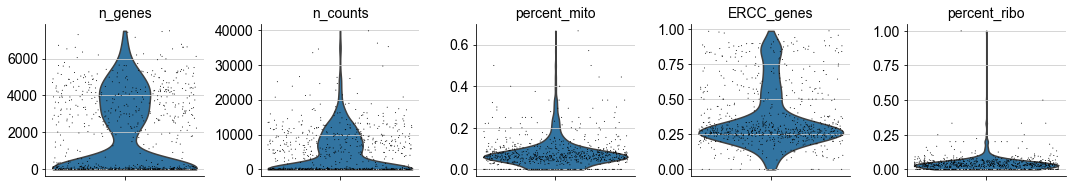

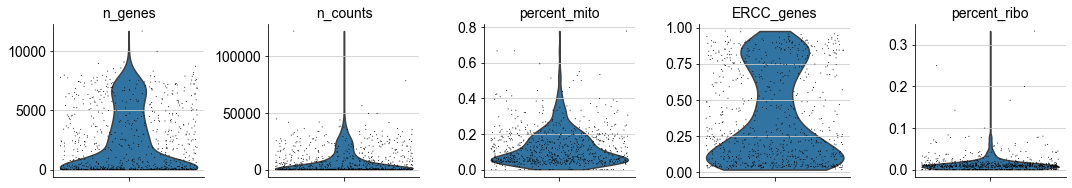

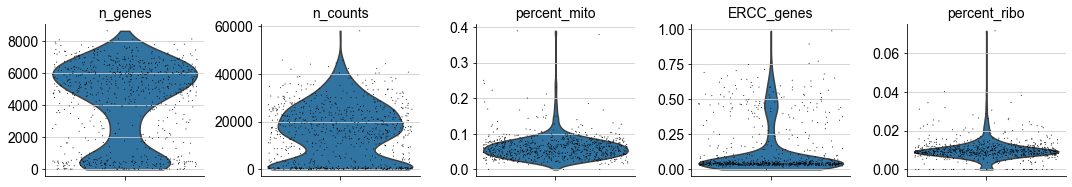

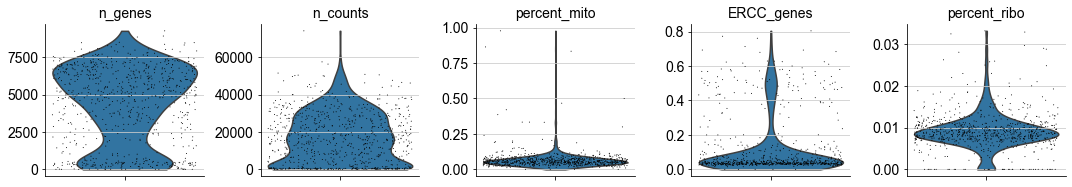

In [16]:
stages = ["E11", "E12", "E13", "E15", "E18", "adult", "P4", "P7"]
for st in stages:
    print("These are quality assessments of " + st + " before filtering.")
    sc.pl.violin(adata[adata.obs['stage'] == st], ['n_genes', 'n_counts', 'percent_mito','ERCC_genes','percent_ribo'],
             jitter=0.4, multi_panel=True)

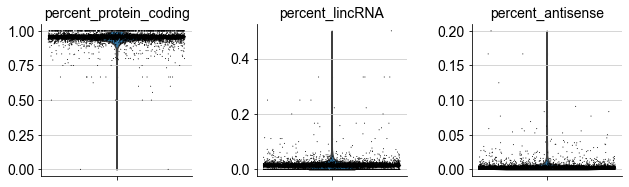

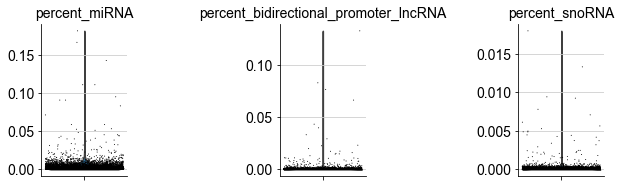

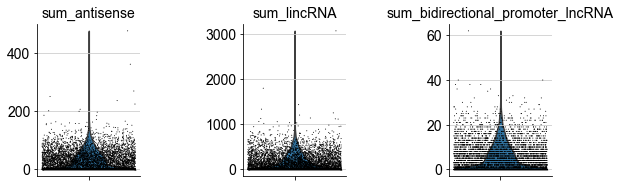

In [17]:
sc.pl.violin(adata, ['percent_protein_coding', 'percent_lincRNA', 'percent_antisense'],
             jitter=0.4, multi_panel=True)
sc.pl.violin(adata, [ 'percent_miRNA', 'percent_bidirectional_promoter_lncRNA', 'percent_snoRNA'],
             jitter=0.4, multi_panel=True)
sc.pl.violin(adata, ['sum_antisense', 'sum_lincRNA', 'sum_bidirectional_promoter_lncRNA'],
             jitter=0.4, multi_panel=True)

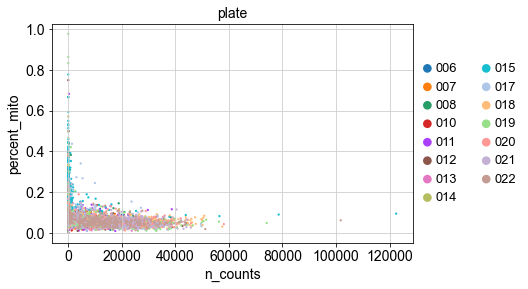

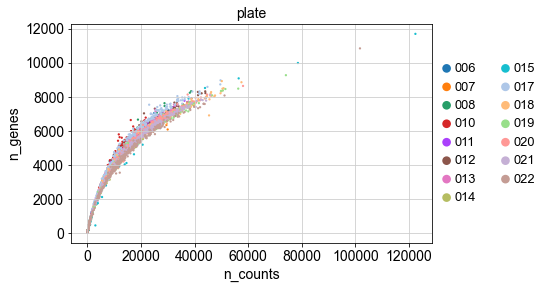

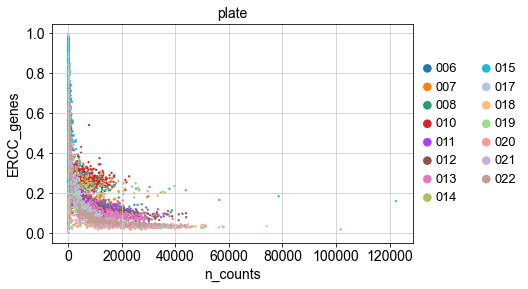

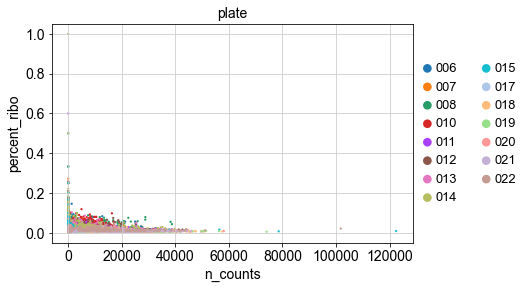

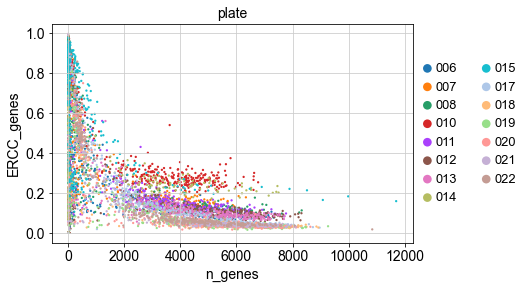

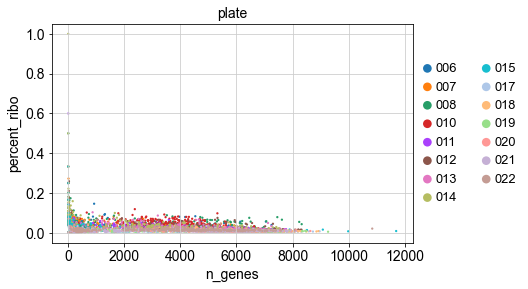

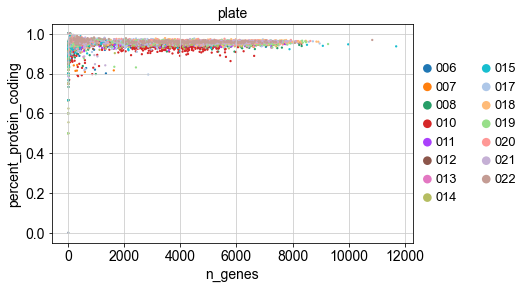

In [18]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito',color = 'plate')
sc.pl.scatter(adata, x='n_counts', y='n_genes',color = 'plate')
sc.pl.scatter(adata, x='n_counts', y='ERCC_genes',color = 'plate')
sc.pl.scatter(adata, x='n_counts', y='percent_ribo',color = 'plate')
sc.pl.scatter(adata, x='n_genes', y='ERCC_genes',color = 'plate')
sc.pl.scatter(adata, x='n_genes', y='percent_ribo',color = 'plate')
sc.pl.scatter(adata, x='n_genes', y='percent_protein_coding',color = 'plate')

Then we save our quality assessed adata.

In [19]:
adata.write('../../data/output/embryo_Hb/Mar2020_embryo_Hb_quality.h5ad')

## Preprocessing
Show the genes that yield the highest fraction of counts in each single cell, across cells.

In [22]:
adata.var_names_make_unique() 

normalizing counts per cell
    finished (0:00:05)


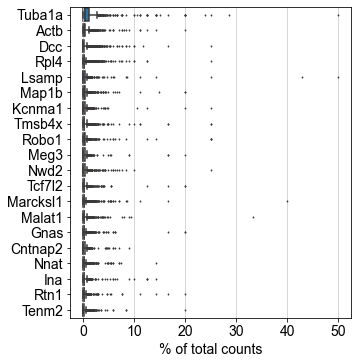

In [23]:
sc.pl.highest_expr_genes(adata, n_top=20)

Then we perform some basic filtering. Here we remove all cells that have less than 2000 cells expressed, and we remove the genes that are present in less than 3 cells.

In [24]:
sc.pp.filter_cells(adata, min_genes=2000)
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 2347 cells that have less than 2000 genes expressed
filtered out 7505 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 3390 × 30452 
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

### Here we perform the final filtering.
We filter out cells that:
- have less than 50.000 counts
- express less than 15% of mitochondrial genes
- express less than 20% of ribosomal genes
- express less than 30% of ERCC spike-in genes
- express more than 85% of protein coding genes

In [25]:
adata = adata[adata.obs['n_counts'] < 50000, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]
adata = adata[adata.obs['percent_ribo'] < 0.2, :]
adata = adata[adata.obs['ERCC_genes'] < 0.3, :]
adata = adata[adata.obs['percent_protein_coding'] > 0.85, :]
adata

View of AnnData object with n_obs × n_vars = 3304 × 30452 
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

Below we print and plot the quality assessments after filtering (preprocessing)

In [26]:
print(np.median(adata.obs['ERCC_genes']), 'median % are ERCC_genes before filtering')
print(np.median(adata.obs['percent_mito']), "median mito_genes/total before filtering, without ERCC")
print(np.median(adata.obs['n_total_counts']), "median number of reads with ERCC per cell")
print(np.median(adata.obs['n_counts']), "median number of reads per cell, without ERCC and mito")
print(np.median(adata.obs['percent_ribo']), "median % of ribosomal genes per cell")
print(np.median(adata.obs['n_genes']), "median number of genes per cell, without ERCC and mito")
print(np.median(adata.obs['percent_protein_coding']), "median % of protein_coding genes per cell")
print(np.median(adata.obs['percent_lincRNA']), "median % of lincRNA genes per cell")
print(np.median(adata.obs['percent_antisense']), "median % of antisense genes per cell")
print(np.median(adata.obs['percent_miRNA']), "median % of miRNA genes per cell")
print(np.median(adata.obs['percent_bidirectional_promoter_lncRNA']), "median % of bidirectional_promoter_lncRNA genes per cell")
print(np.median(adata.obs['percent_snoRNA']), "median % of snoRNA genes per cell")
print(np.median(adata.obs['sum_miRNA']), "median of total miRNA genes per cell")
print(np.median(adata.obs['sum_antisense']), "median of total antisense genes per cell")
print(np.median(adata.obs['sum_lincRNA']), "median of total lincRNA genes per cell")

0.084510155 median % are ERCC_genes before filtering
0.052434318 median mito_genes/total before filtering, without ERCC
16982.182 median number of reads with ERCC per cell
14396.686 median number of reads per cell, without ERCC and mito
0.015030706 median % of ribosomal genes per cell
4955.0 median number of genes per cell, without ERCC and mito
0.9551359 median % of protein_coding genes per cell
0.015157439 median % of lincRNA genes per cell
0.0029623369 median % of antisense genes per cell
0.002789408 median % of miRNA genes per cell
0.0005023731 median % of bidirectional_promoter_lncRNA genes per cell
0.00011839847 median % of snoRNA genes per cell
42.044037 median of total miRNA genes per cell
44.006348 median of total antisense genes per cell
219.40396 median of total lincRNA genes per cell


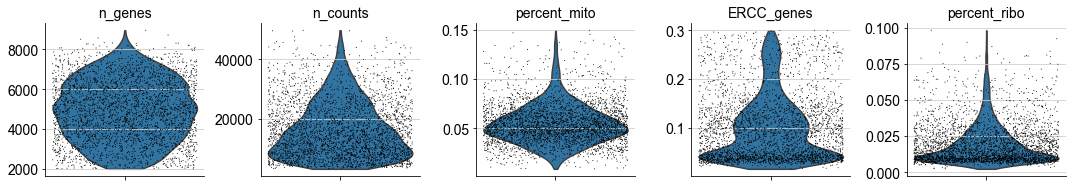

In [27]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito','ERCC_genes','percent_ribo'],
             jitter=0.4, multi_panel=True

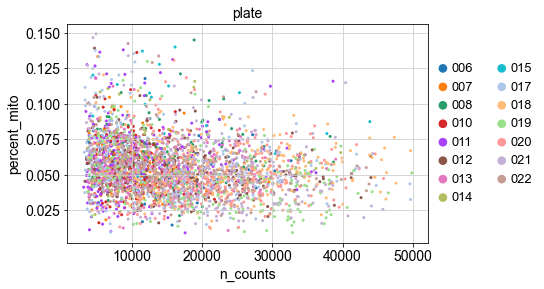

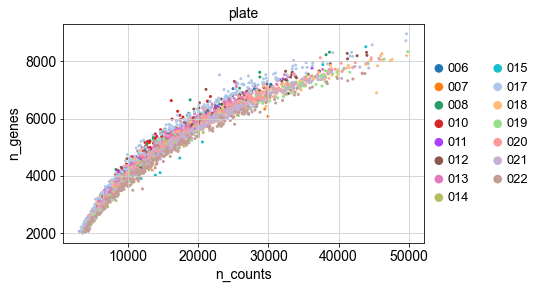

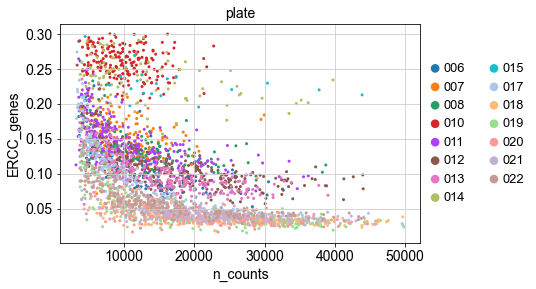

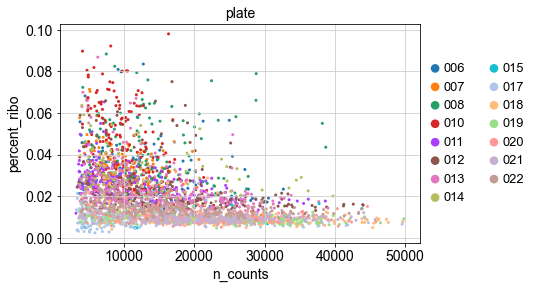

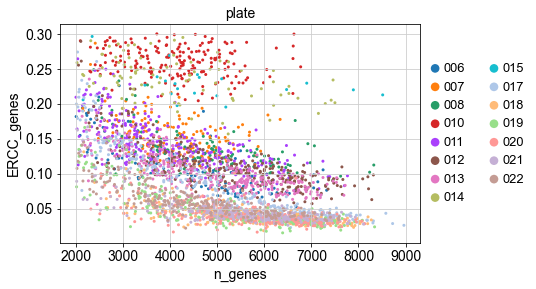

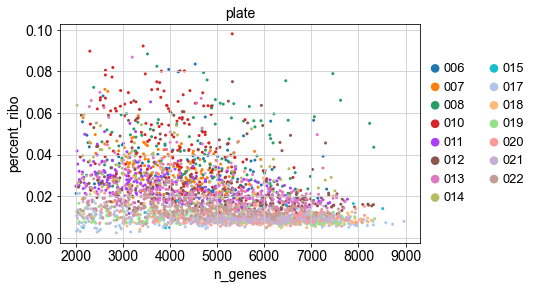

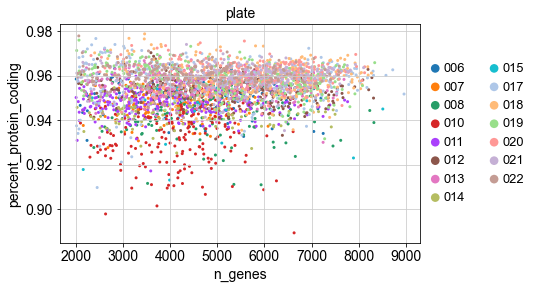

In [28]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito',color = 'plate')
sc.pl.scatter(adata, x='n_counts', y='n_genes',color = 'plate')
sc.pl.scatter(adata, x='n_counts', y='ERCC_genes',color = 'plate')
sc.pl.scatter(adata, x='n_counts', y='percent_ribo',color = 'plate')
sc.pl.scatter(adata, x='n_genes', y='ERCC_genes',color = 'plate')
sc.pl.scatter(adata, x='n_genes', y='percent_ribo',color = 'plate')
sc.pl.scatter(adata, x='n_genes', y='percent_protein_coding',color = 'plate')

Then we save the filtered data.

In [29]:
adata.write('../../data/output/embryo_Hb/Mar2020_embryo_Hb_filtered.h5ad')

## Pou4f1+ selection
We are only interested in the cells that express the habenula gene Pou4f1, so here we filter on the presence of that gene and save the data.

In [31]:
adata

View of AnnData object with n_obs × n_vars = 3304 × 30452 
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

In [32]:
test = adata[(adata.obs_vector('Pou4f1') > 0.0), :]

In [33]:
test

View of AnnData object with n_obs × n_vars = 2773 × 30452 
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

In [34]:
adata = test

In [35]:
adata.write('../../data/output/embryo_Hb/Mar2020_embryo_Hb_filtered_Pou4f1_only.h5ad')

In [36]:
#adata = sc.read('../../data/output/embryo_Hb/Mar2020_embryo_Hb_filtered_Pou4f1_only.h5ad')